# Car Classification Model Training

This notebook trains a Hybrid ResNet-ViT model for Indonesian car classification using the collected dataset. The model combines ResNet-50 as a feature extractor with a Vision Transformer for classification.

## Dataset Structure
- **Classes**: 8 Indonesian car types (hatchback, mpv, offroad, pickup, sedan, suv, truck, van)
- **Architecture**: Hybrid ResNet-ViT combining CNN and Transformer
- **Training Strategy**: Transfer learning with data augmentation
- **Class Imbalance**: Handled using weighted loss function for better minority class performance

## Training Process
1. Dataset exploration and class imbalance analysis
2. Model training with weighted loss and comprehensive tracking
3. Performance analysis with detailed charts and metrics
4. Model evaluation with per-class analysis and confusion matrix
5. Training insights and recommendations for optimization

In [1]:
!rm -rf code data_processing logs models code state.db
!rm 1_run_scraper_into_dataset.ipynb 2_train_the_classification_model.ipynb requirements.txt

In [2]:
!git clone -b feat/pretrained-model https://github.com/luthfiarifin/hybrid-envit-car-retrieval.git code
!mv code/* .
!ls

Cloning into 'code'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 137 (delta 18), reused 31 (delta 12), pack-reused 96 (from 2)
Receiving objects: 100% (137/137), 333.54 MiB | 42.44 MiB/s, done.
Resolving deltas: 100% (45/45), done.
1_run_scraper_into_dataset.ipynb	code		 models
2_train_the_classification_model.ipynb	data_processing  requirements.txt


In [3]:
IS_IMPORT_FROM_KAGGLE = True

if IS_IMPORT_FROM_KAGGLE:
    import kagglehub
    DATASET_DIR = kagglehub.dataset_download("muhammadluthfiarifin/indonesian-cars-classification-dataset", path="dataset")
else:
    DATASET_DIR = "data_processing/data/dataset"

In [4]:
# Import required libraries

import torch
import time
from datetime import datetime

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB"
    )

Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA memory: 15.9 GB


2025-06-24 01:45:25.375185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750729525.397560     449 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750729525.404446     449 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


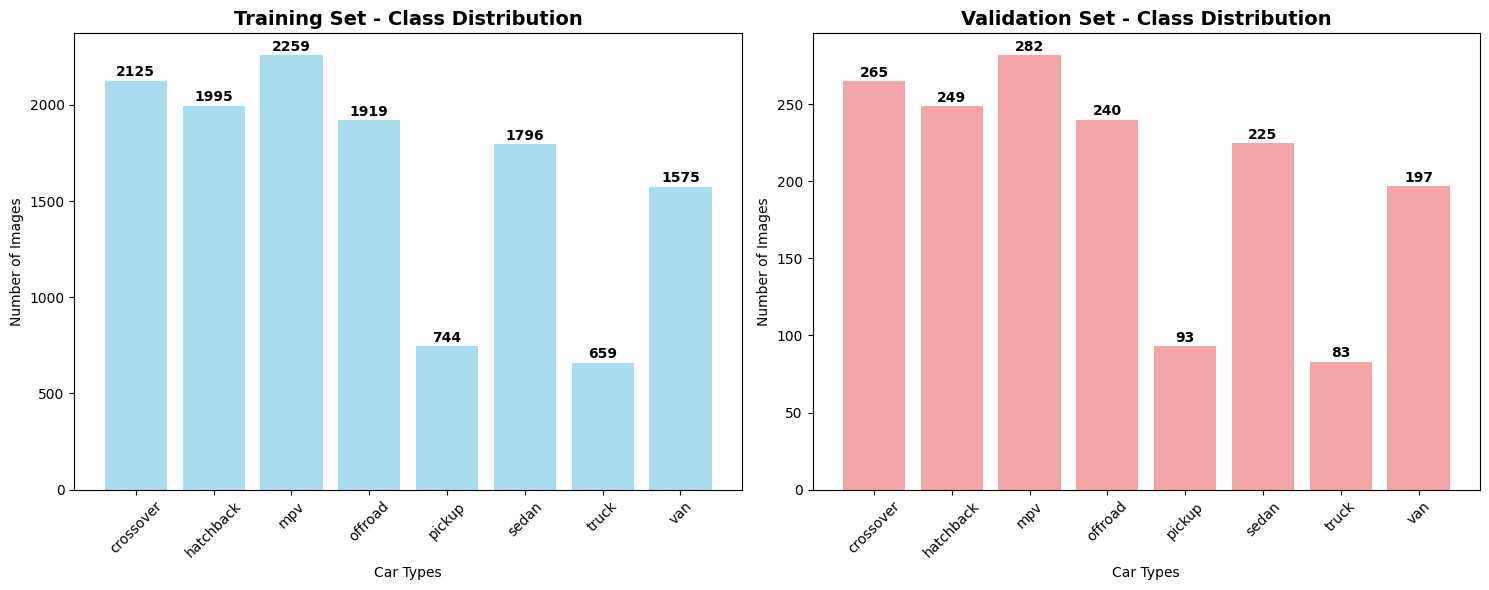


=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===
Using device: cuda
Logging to TensorBoard: logs/train_classification/run_1750729532
Using weighted CrossEntropyLoss with weights: tensor([0.7689, 0.8190, 0.7233, 0.8515, 2.1962, 0.9098, 2.4795, 1.0375],
       device='cuda:0')

📊 Class Distribution Analysis:
Class        Count    Percentage Imbalance Ratio
--------------------------------------------------
crossover    2125     16.3      % 1.06           x
hatchback    1995     15.3      % 1.13           x
mpv          2259     17.3      % 1.00           x
offroad      1919     14.7      % 1.18           x
pickup       744      5.7       % 3.04           x
sedan        1796     13.7      % 1.26           x
truck        659      5.0       % 3.43           x
van          1575     12.0      % 1.43           x

📈 Imbalance Factor: 3.43x (Most frequent / Least frequent)
⚠️  Moderate imbalance detected. Weighted loss recommended.
Trainer initialized successfully!
Tr

In [5]:
# Training configuration

from models.classification.train_classification import CarClassifierTrainer
from models.classification.train_classification_eval import DatasetExplorer


CONFIG = {
    "train_dir": f"{DATASET_DIR}/train",
    "val_dir": f"{DATASET_DIR}/val",
    "num_classes": 8,
    "learning_rate": 1e-4,
    "batch_size": 64,
    "num_epochs": 50,
    "result_path": f'models/classification/results/carvit_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth',
    "use_weighted_loss": True,
    "use_class_balancing": False,
    "num_workers": 8,
    "early_stopping_patience": 7,
    "early_stopping_delta": 0.001,
    "early_stopping_verbose": True,
    "pretrained": True,
}

# Generate and summary report
explorer = DatasetExplorer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
)
explorer.summary_report()

# Initialize the trainer
print("\n=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===")
trainer = CarClassifierTrainer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
    num_classes=CONFIG["num_classes"],
    learning_rate=CONFIG["learning_rate"],
    batch_size=CONFIG["batch_size"],
    num_epochs=CONFIG["num_epochs"],
    result_path=CONFIG["result_path"],
    use_weighted_loss=CONFIG["use_weighted_loss"],
    use_class_balancing=CONFIG["use_class_balancing"],
    num_workers=CONFIG["num_workers"],
    early_stopping_patience=CONFIG["early_stopping_patience"],
    early_stopping_delta=CONFIG["early_stopping_delta"],
    early_stopping_verbose=CONFIG["early_stopping_verbose"],
    pretrained=CONFIG["pretrained"],
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(trainer.train_dataset)}")
print(f"Validation samples: {len(trainer.val_dataset)}")
print(f"Number of batches per epoch: {len(trainer.train_loader)}")
print(f"Class names: {trainer.train_dataset.classes}")

In [6]:
# Start training with detailed tracking
start_time = time.time()

# Execute training
training_results = trainer.train()

# Print training results
total_time = time.time() - start_time
print(f"\n=== Training Completed in {total_time:.2f} seconds ===")

Starting training with detailed tracking and early stopping...
Early Stopping - Patience: 7, Delta: 0.001
Model parameters: 16,888,506
Trainable parameters: 16,888,506

Epoch 1/50


100%|██████████| 205/205 [02:53<00:00,  1.18it/s, loss=1.3] 


Validation accuracy: 47.18%
Validation loss: 1.4345
Train Loss: 1.7848 | Train Acc: 26.51%
Val Loss: 1.4345 | Val Acc: 47.18%
Time: 190.04s | LR: 1.00e-04
🎉 New best accuracy: 47.18%
Validation loss decreased (inf --> 1.434472).  Saving model ...

Epoch 2/50


100%|██████████| 205/205 [02:52<00:00,  1.19it/s, loss=1.28] 


Validation accuracy: 60.59%
Validation loss: 1.0670
Train Loss: 1.2788 | Train Acc: 46.68%
Val Loss: 1.0670 | Val Acc: 60.59%
Time: 180.83s | LR: 1.00e-04
🎉 New best accuracy: 60.59%
Validation loss decreased (1.434472 --> 1.066966).  Saving model ...

Epoch 3/50


100%|██████████| 205/205 [02:51<00:00,  1.19it/s, loss=0.875]


Validation accuracy: 67.81%
Validation loss: 0.8910
Train Loss: 1.0277 | Train Acc: 57.18%
Val Loss: 0.8910 | Val Acc: 67.81%
Time: 180.55s | LR: 1.00e-04
🎉 New best accuracy: 67.81%
Validation loss decreased (1.066966 --> 0.891010).  Saving model ...

Epoch 4/50


100%|██████████| 205/205 [02:52<00:00,  1.19it/s, loss=0.665]


Validation accuracy: 73.56%
Validation loss: 0.7616
Train Loss: 0.8585 | Train Acc: 63.56%
Val Loss: 0.7616 | Val Acc: 73.56%
Time: 181.11s | LR: 1.00e-04
🎉 New best accuracy: 73.56%
Validation loss decreased (0.891010 --> 0.761572).  Saving model ...

Epoch 5/50


100%|██████████| 205/205 [02:51<00:00,  1.20it/s, loss=0.584]


Validation accuracy: 75.58%
Validation loss: 0.6709
Train Loss: 0.7491 | Train Acc: 68.74%
Val Loss: 0.6709 | Val Acc: 75.58%
Time: 179.92s | LR: 1.00e-04
🎉 New best accuracy: 75.58%
Validation loss decreased (0.761572 --> 0.670871).  Saving model ...

Epoch 6/50


100%|██████████| 205/205 [02:51<00:00,  1.19it/s, loss=0.746]


Validation accuracy: 77.91%
Validation loss: 0.6166
Train Loss: 0.6402 | Train Acc: 73.13%
Val Loss: 0.6166 | Val Acc: 77.91%
Time: 180.23s | LR: 1.00e-04
🎉 New best accuracy: 77.91%
Validation loss decreased (0.670871 --> 0.616648).  Saving model ...

Epoch 7/50


100%|██████████| 205/205 [02:52<00:00,  1.19it/s, loss=0.753]


Validation accuracy: 79.93%
Validation loss: 0.5604
Train Loss: 0.5774 | Train Acc: 76.26%
Val Loss: 0.5604 | Val Acc: 79.93%
Time: 181.21s | LR: 1.00e-04
🎉 New best accuracy: 79.93%
Validation loss decreased (0.616648 --> 0.560363).  Saving model ...

Epoch 8/50


100%|██████████| 205/205 [02:51<00:00,  1.19it/s, loss=0.565]


Validation accuracy: 80.97%
Validation loss: 0.5286
Train Loss: 0.5145 | Train Acc: 78.53%
Val Loss: 0.5286 | Val Acc: 80.97%
Time: 180.51s | LR: 1.00e-04
🎉 New best accuracy: 80.97%
Validation loss decreased (0.560363 --> 0.528591).  Saving model ...

Epoch 9/50


100%|██████████| 205/205 [02:51<00:00,  1.19it/s, loss=0.922]


Validation accuracy: 83.05%
Validation loss: 0.4909
Train Loss: 0.4616 | Train Acc: 81.36%
Val Loss: 0.4909 | Val Acc: 83.05%
Time: 180.26s | LR: 1.00e-04
🎉 New best accuracy: 83.05%
Validation loss decreased (0.528591 --> 0.490865).  Saving model ...

Epoch 10/50


100%|██████████| 205/205 [02:52<00:00,  1.19it/s, loss=0.618]


Validation accuracy: 83.54%
Validation loss: 0.4792
Train Loss: 0.4147 | Train Acc: 83.06%
Val Loss: 0.4792 | Val Acc: 83.54%
Time: 180.96s | LR: 1.00e-04
🎉 New best accuracy: 83.54%
Validation loss decreased (0.490865 --> 0.479213).  Saving model ...

Epoch 11/50


100%|██████████| 205/205 [02:51<00:00,  1.20it/s, loss=0.367]


Validation accuracy: 84.15%
Validation loss: 0.4657
Train Loss: 0.3774 | Train Acc: 84.36%
Val Loss: 0.4657 | Val Acc: 84.15%
Time: 180.32s | LR: 1.00e-04
🎉 New best accuracy: 84.15%
Validation loss decreased (0.479213 --> 0.465720).  Saving model ...

Epoch 12/50


100%|██████████| 205/205 [02:52<00:00,  1.19it/s, loss=0.174]


Validation accuracy: 85.80%
Validation loss: 0.4322
Train Loss: 0.3425 | Train Acc: 85.43%
Val Loss: 0.4322 | Val Acc: 85.80%
Time: 181.20s | LR: 1.00e-04
🎉 New best accuracy: 85.80%
Validation loss decreased (0.465720 --> 0.432184).  Saving model ...

Epoch 13/50


100%|██████████| 205/205 [02:52<00:00,  1.19it/s, loss=0.272]


Validation accuracy: 86.11%
Validation loss: 0.4227
Train Loss: 0.3206 | Train Acc: 86.38%
Val Loss: 0.4227 | Val Acc: 86.11%
Time: 181.45s | LR: 1.00e-04
🎉 New best accuracy: 86.11%
Validation loss decreased (0.432184 --> 0.422658).  Saving model ...

Epoch 14/50


100%|██████████| 205/205 [02:52<00:00,  1.19it/s, loss=0.366]


Validation accuracy: 86.35%
Validation loss: 0.4181
Train Loss: 0.2934 | Train Acc: 88.11%
Val Loss: 0.4181 | Val Acc: 86.35%
Time: 181.20s | LR: 1.00e-04
🎉 New best accuracy: 86.35%
Validation loss decreased (0.422658 --> 0.418126).  Saving model ...

Epoch 15/50


100%|██████████| 205/205 [02:53<00:00,  1.18it/s, loss=0.517]


Validation accuracy: 87.33%
Validation loss: 0.4051
Train Loss: 0.2633 | Train Acc: 88.55%
Val Loss: 0.4051 | Val Acc: 87.33%
Time: 182.09s | LR: 1.00e-04
🎉 New best accuracy: 87.33%
Validation loss decreased (0.418126 --> 0.405148).  Saving model ...

Epoch 16/50


100%|██████████| 205/205 [02:52<00:00,  1.19it/s, loss=0.421] 


Validation accuracy: 87.64%
Validation loss: 0.3929
Train Loss: 0.2464 | Train Acc: 89.73%
Val Loss: 0.3929 | Val Acc: 87.64%
Time: 181.92s | LR: 1.00e-04
🎉 New best accuracy: 87.64%
Validation loss decreased (0.405148 --> 0.392934).  Saving model ...

Epoch 17/50


100%|██████████| 205/205 [02:50<00:00,  1.20it/s, loss=0.387] 


Validation accuracy: 87.52%
Validation loss: 0.3843
Train Loss: 0.2353 | Train Acc: 89.89%
Val Loss: 0.3843 | Val Acc: 87.52%
Time: 179.35s | LR: 1.00e-04
Validation loss decreased (0.392934 --> 0.384255).  Saving model ...

Epoch 18/50


100%|██████████| 205/205 [02:51<00:00,  1.20it/s, loss=0.724] 


Validation accuracy: 88.25%
Validation loss: 0.3740
Train Loss: 0.2172 | Train Acc: 90.78%
Val Loss: 0.3740 | Val Acc: 88.25%
Time: 180.04s | LR: 1.00e-04
🎉 New best accuracy: 88.25%
Validation loss decreased (0.384255 --> 0.373985).  Saving model ...

Epoch 19/50


100%|██████████| 205/205 [02:51<00:00,  1.20it/s, loss=0.222] 


Validation accuracy: 88.56%
Validation loss: 0.3861
Train Loss: 0.1971 | Train Acc: 91.40%
Val Loss: 0.3861 | Val Acc: 88.56%
Time: 179.93s | LR: 1.00e-04
🎉 New best accuracy: 88.56%
EarlyStopping counter: 1 out of 7

Epoch 20/50


100%|██████████| 205/205 [02:51<00:00,  1.20it/s, loss=0.375] 


Validation accuracy: 88.98%
Validation loss: 0.3897
Train Loss: 0.1911 | Train Acc: 91.75%
Val Loss: 0.3897 | Val Acc: 88.98%
Time: 179.64s | LR: 1.00e-04
🎉 New best accuracy: 88.98%
EarlyStopping counter: 2 out of 7

Epoch 21/50


100%|██████████| 205/205 [02:51<00:00,  1.20it/s, loss=0.179] 


Validation accuracy: 89.41%
Validation loss: 0.3842
Train Loss: 0.1874 | Train Acc: 92.02%
Val Loss: 0.3842 | Val Acc: 89.41%
Time: 180.16s | LR: 1.00e-04
🎉 New best accuracy: 89.41%
EarlyStopping counter: 3 out of 7

Epoch 22/50


100%|██████████| 205/205 [02:51<00:00,  1.19it/s, loss=0.189] 


Validation accuracy: 88.92%
Validation loss: 0.3915
Train Loss: 0.1634 | Train Acc: 92.91%
Val Loss: 0.3915 | Val Acc: 88.92%
Time: 180.59s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 23/50


100%|██████████| 205/205 [02:51<00:00,  1.19it/s, loss=0.704] 


Validation accuracy: 88.68%
Validation loss: 0.3933
Train Loss: 0.1570 | Train Acc: 93.25%
Val Loss: 0.3933 | Val Acc: 88.68%
Time: 180.46s | LR: 1.00e-04
EarlyStopping counter: 5 out of 7

Epoch 24/50


100%|██████████| 205/205 [02:52<00:00,  1.19it/s, loss=0.261] 


Validation accuracy: 89.53%
Validation loss: 0.3926
Train Loss: 0.1520 | Train Acc: 93.11%
Val Loss: 0.3926 | Val Acc: 89.53%
Time: 180.98s | LR: 1.00e-04
🎉 New best accuracy: 89.53%
EarlyStopping counter: 6 out of 7

Epoch 25/50


100%|██████████| 205/205 [02:51<00:00,  1.20it/s, loss=0.237] 


Validation accuracy: 88.98%
Validation loss: 0.3983
Train Loss: 0.1454 | Train Acc: 93.34%
Val Loss: 0.3983 | Val Acc: 88.98%
Time: 180.24s | LR: 1.00e-04
EarlyStopping counter: 7 out of 7

🛑 Early stopping triggered at epoch 25
Best validation loss: 0.373985

Training completed!
Training stopped early at epoch 25 due to no improvement in validation loss
Best validation accuracy: 89.53%
Loading best model with validation loss: 0.373985
Best accuracy model saved to models/classification/results/carvit_model_20250624_014531_best_acc.pth

=== Training Completed in 4529.03 seconds ===


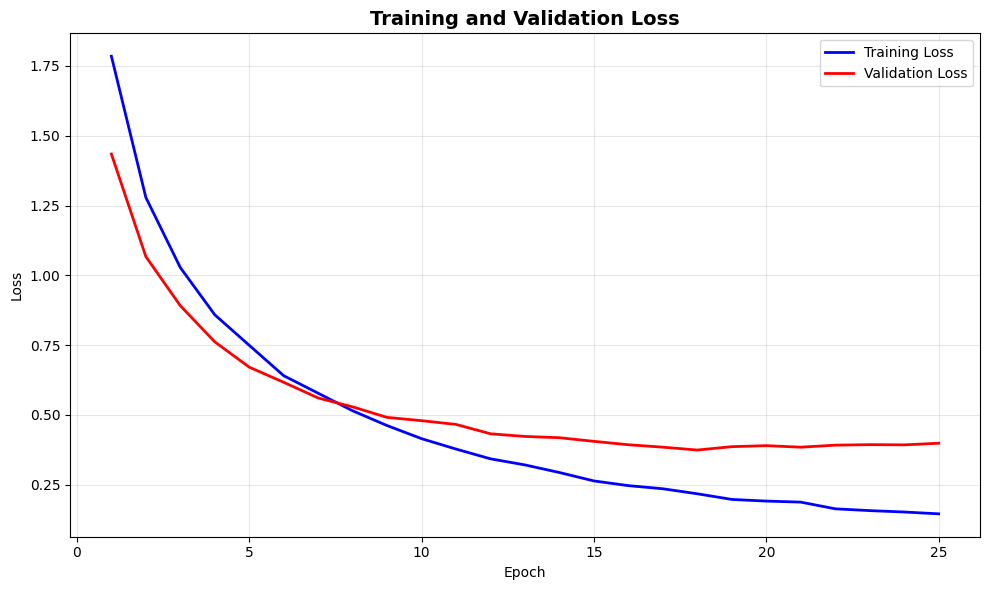

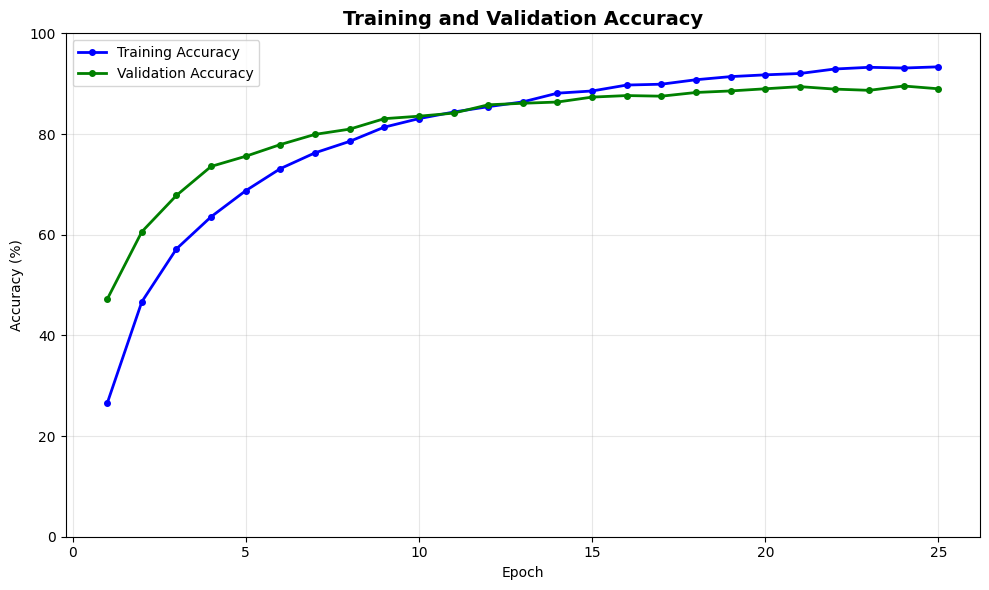

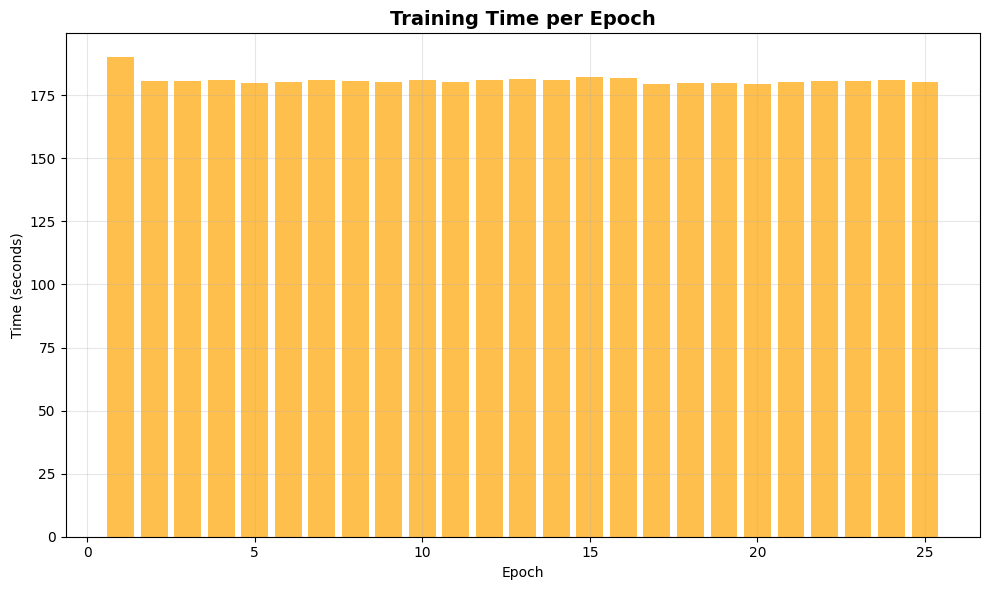

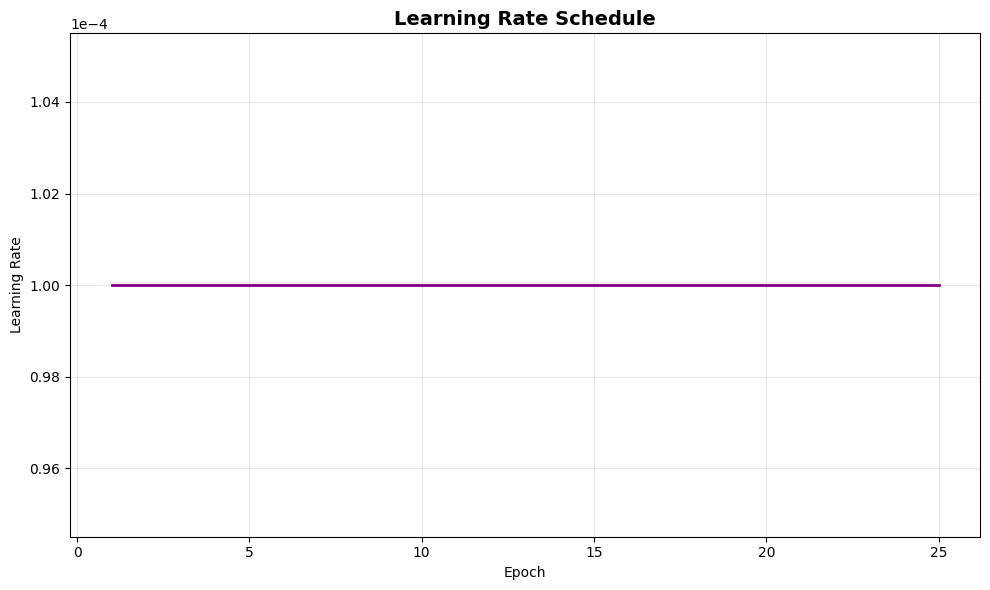

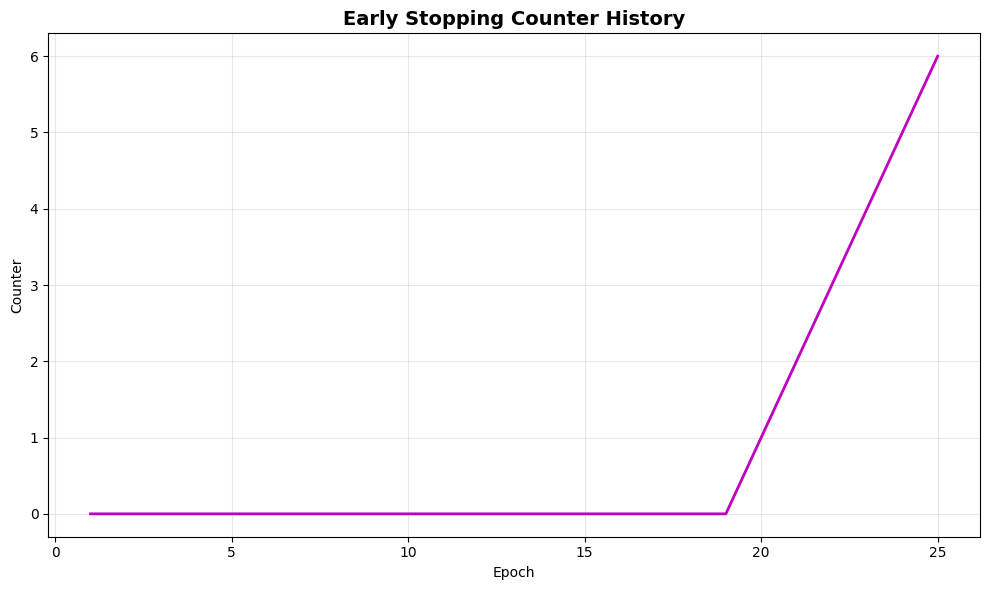


🛑 Early Stopping Analysis:
Early stopping triggered at epoch 25/50.
Epochs saved: 25
Time saved: ~75.4 minutes
Efficiency gain: 50.0%

📈 Detailed Training Statistics:
- Loss Reduction: 1.7848 → 0.1454 (91.9% improvement)
- Best Accuracy: 89.53% (Epoch 24)
- Total Training Time: 75.42 minutes
- Average Time per Epoch: 181.01s
- Fastest Epoch: 179.35s
- Slowest Epoch: 190.04s
- Early Stopping Counter History: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6]

📋 Training Metrics Table (Last 5 Epochs):
 Epoch  Train_Loss  Val_Loss  Val_Accuracy  Epoch_Time  Learning_Rate  ES_Counter
    21      0.1874    0.3842         89.41      180.16         0.0001           2
    22      0.1634    0.3915         88.92      180.59         0.0001           3
    23      0.1570    0.3933         88.68      180.46         0.0001           4
    24      0.1520    0.3926         89.53      180.98         0.0001           5
    25      0.1454    0.3983         88.98      180.24     

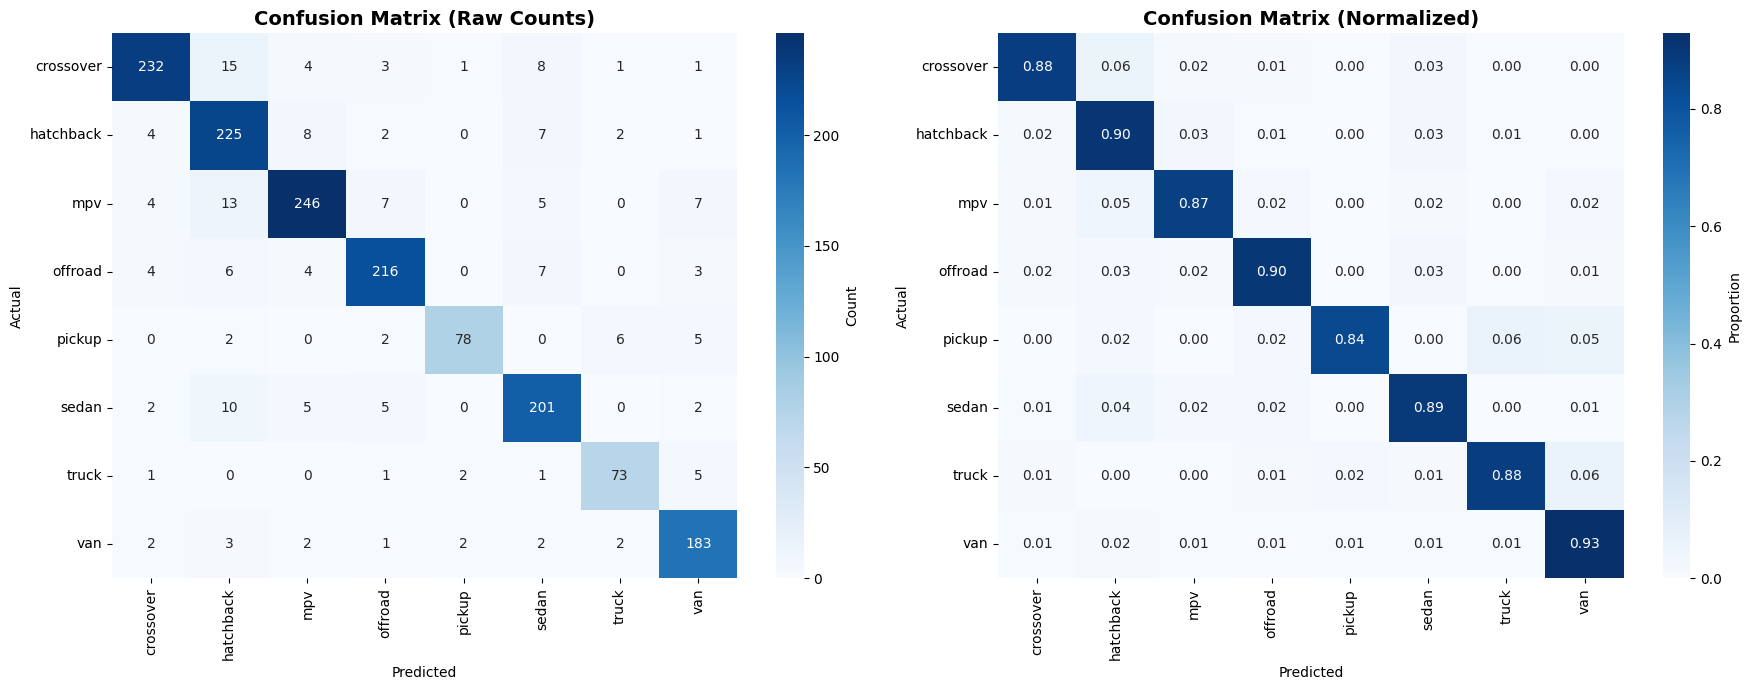


📊 Detailed Classification Report:
              precision    recall  f1-score   support

   crossover     0.9317    0.8755    0.9027       265
   hatchback     0.8212    0.9036    0.8604       249
         mpv     0.9145    0.8723    0.8929       282
     offroad     0.9114    0.9000    0.9057       240
      pickup     0.9398    0.8387    0.8864        93
       sedan     0.8701    0.8933    0.8816       225
       truck     0.8690    0.8795    0.8743        83
         van     0.8841    0.9289    0.9059       197

    accuracy                         0.8898      1634
   macro avg     0.8927    0.8865    0.8887      1634
weighted avg     0.8920    0.8898    0.8901      1634


⚖️ Class Imbalance Impact Analysis:

📈 Class Group Performance:
Minority Classes (4): ['pickup', 'sedan', 'truck', 'van']
Average Accuracy: 88.51%
Majority Classes (4): ['crossover', 'hatchback', 'mpv', 'offroad']
Average Accuracy: 88.79%
Performance Gap: 0.27% (Majority better)


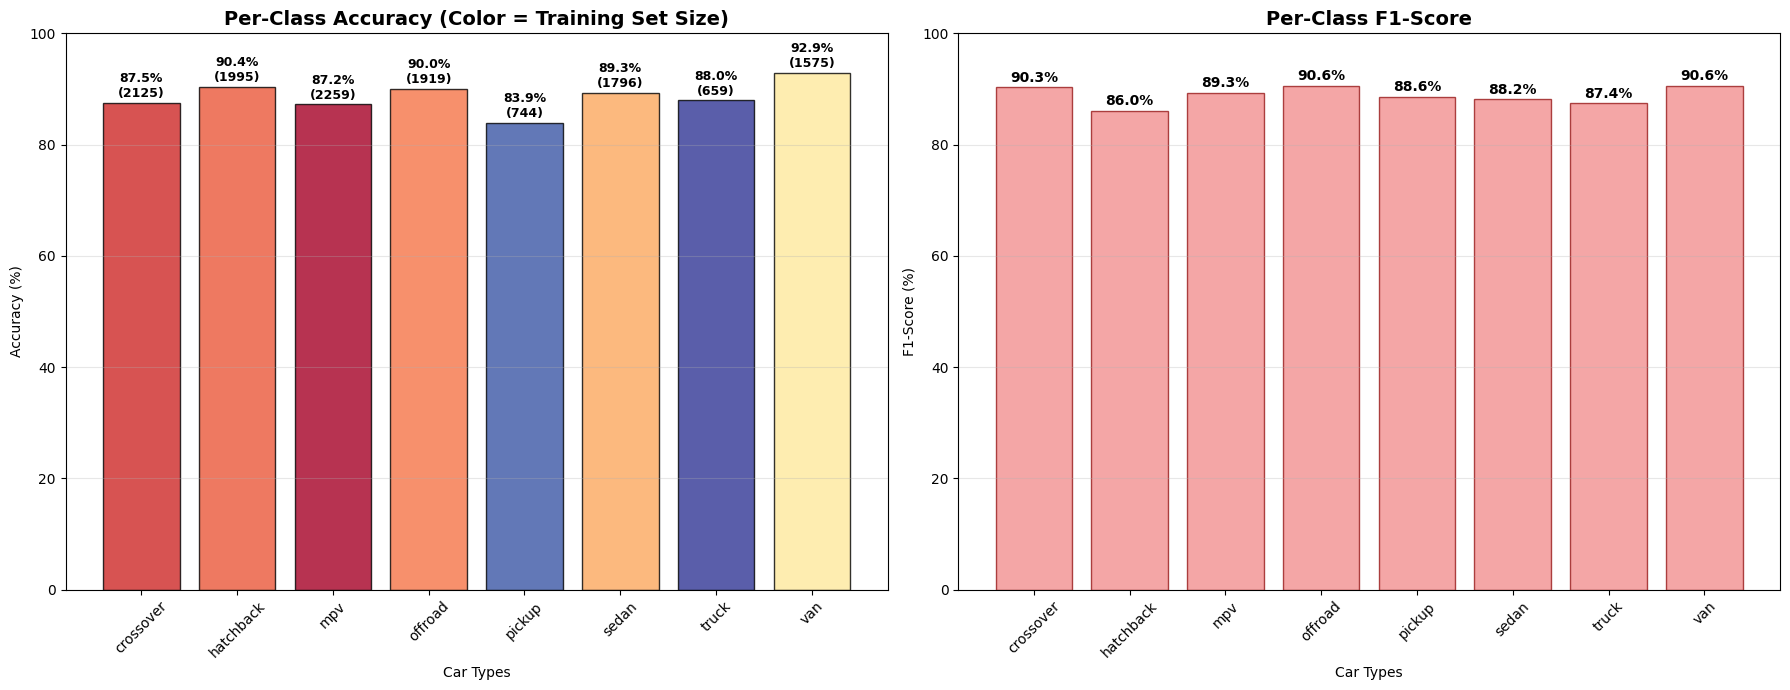


🛑 Early stopping summary saved to: models/classification/reports/early_stopping_summary_20250624_030351.json

💾 Training history saved to: models/classification/reports/training_history_20250624_030351.csv
📊 Class performance saved to: models/classification/reports/class_performance_20250624_030351.csv
🎯 Best model saved to: models/classification/results/carvit_model_20250624_014531.pth
🏆 Best accuracy model saved to: models/classification/results/carvit_model_20250624_014531_best_acc.pth

🎉 Training Analysis Complete!
🎯 Final Summary:
- Training completed in 25 epochs (planned: 50)
- Best validation accuracy: 89.53%
- Early stopping: Activated
- Total training time: 75.42 minutes
- Time saved by early stopping: 75.4 minutes
- Class imbalance: Moderate (ratio: 3.43x)
- Model saved with best validation loss: 0.373985


In [7]:
# Generate the full report
from models.classification.train_classification_eval import TrainingEvaluation

report = TrainingEvaluation(trainer, CONFIG, training_results)

report.full_report()

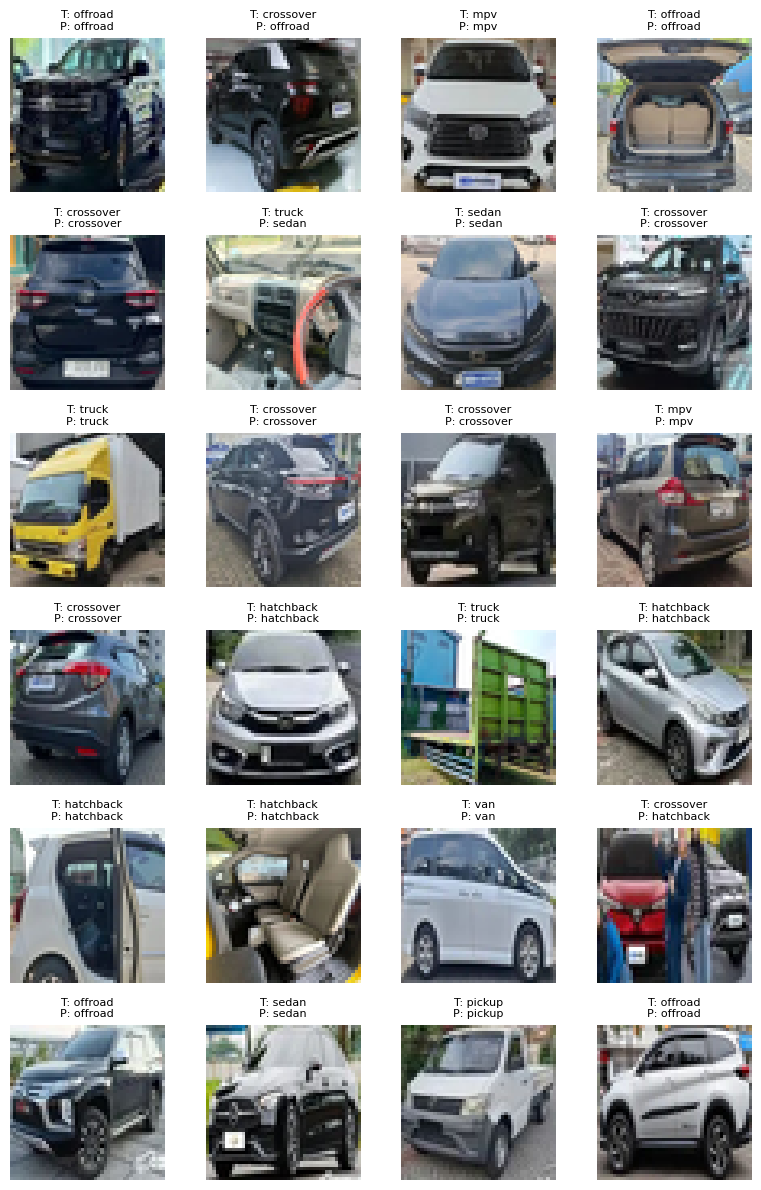

Test Accuracy: 87.50% (21/24)


In [8]:
# Test the classification model test images and display predictions
import os

from models.classification.test_classification import CarClassificationTester

test_dir = f"{DATASET_DIR}/test"
class_names = [
    d for d in sorted(os.listdir(test_dir)) if os.path.isdir(os.path.join(test_dir, d))
]
tester = CarClassificationTester(
    test_dir=test_dir,
    class_names=class_names,
    model_path=None,
    grid_rows=6,
    grid_cols=4,
    num_classes=CONFIG["num_classes"],
)

tester.plot_predictions()